# Figure 2 and Figure 3

In [1]:
import pyam
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from pathlib import Path
import string
import numpy as np
plt.style.use(
    "plotting_template.mplstyle"
)

<IPython.core.display.Javascript object>

# Read in the necessary data

In [2]:
data_folder = Path(
    "..","data"
)

In [3]:
data_file = Path(
    data_folder / "AR6_Scenarios_Snapshot.xlsx"
)

In [4]:
meta_file = Path(
    data_folder / "AR6_Scenarios_Updated_Meta.xlsx"
)

In [5]:
df_ar6 = pyam.IamDataFrame(data_file)

pyam - INFO: Running in a notebook, setting up a basic logging at level INFO
pyam.core - INFO: Reading file ../data/AR6_Scenarios_Snapshot.xlsx
pyam.core - INFO: Reading meta indicators


In [6]:
df_ar6.load_meta(meta_file)

pyam.core - INFO: Reading meta indicators


# Figure 2
* Panel a: Peak exceedance probability
* Panel b: Difference between peak and end of century warming
* Panel c: Post peak temperature trend

In [7]:
plot_figure_2 = df_ar6.filter(
    Category_rolling_mean=["C1", "C2", "C3"],
    variable =[
        "AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|Rolling Mean|50.0th Percentile",
        "AR6 climate diagnostics|Exceedance Probability 1.5C|MAGICCv7.5.3|Rolling Mean",
        "AR6 climate diagnostics|Exceedance Probability 2.0C|MAGICCv7.5.3|Rolling Mean"
    ]
)

In [8]:
plot_figure_2.unit_mapping

{'AR6 climate diagnostics|Exceedance Probability 1.5C|MAGICCv7.5.3|Rolling Mean': 'dimensionless',
 'AR6 climate diagnostics|Exceedance Probability 2.0C|MAGICCv7.5.3|Rolling Mean': 'dimensionless',
 'AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|Rolling Mean|50.0th Percentile': 'K'}

In [9]:
plot_figure_2.rename(
    variable = {
        "AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|Rolling Mean|50.0th Percentile": "Temperature"
    },
    inplace = True
)

# Set peak and end of century characteristics.

Peak and end of century warming.

In [10]:
plot_figure_2.set_meta_from_data(
    variable="Temperature",
    method=np.max,
    name="peak_warming"
)

In [11]:
plot_figure_2.set_meta_from_data(
    variable="Temperature",
    year=2100,
    name="2100_warming"
)

Now, we need to identify the year of peak warming.

In [12]:
temp = plot_figure_2.filter(
    variable="Temperature"
).timeseries()

In [13]:
plot_figure_2.set_meta(
    temp.apply(
        lambda x: x[x == x.max()].index[0],
        axis=1
    ),
    name="year_of_peak_warming"
)

Exceedance probability for 1.5 and 2

In [14]:
plot_figure_2.set_meta_from_data(
    variable="AR6 climate diagnostics|Exceedance Probability 2.0C|MAGICCv7.5.3|Rolling Mean",
    method=np.max,
    name="peak_exceedance_2p0"
)

Exceedance probability for 2

In [15]:
plot_figure_2.set_meta_from_data(
    variable="AR6 climate diagnostics|Exceedance Probability 1.5C|MAGICCv7.5.3|Rolling Mean",
    method=np.max,
    name="peak_exceedance_1p5"
)

Panel 1 data preparation

In [16]:
panel_1_net_zero = (
    plot_figure_2
    .filter(
        netzero = True
    ).meta[[ 
        "peak_exceedance_1p5",
        "peak_exceedance_2p0"    
    ]]
)

panel_1_no_net_zero = (
    plot_figure_2
    .filter(
        netzero = False
    ).meta[[
        "peak_exceedance_1p5",
        "peak_exceedance_2p0"     
    ]]
)

Now we handle the second panel on absolute temperature decline.

In [17]:
plot_figure_2.set_meta(
    plot_figure_2.meta.apply(
        lambda x: x["2100_warming"] - x["peak_warming"],
        axis = 1
    ),
    name = "difference_peak_and_decline"
)

In [18]:
# Normalise in a per decade manner
plot_figure_2.set_meta(
    plot_figure_2.meta.apply(
        lambda x: x["difference_peak_and_decline"] / (2100 - x["year_of_peak_warming"]) if (x["year_of_peak_warming"] < 2100) else 0, 
        axis=1
    ), 
    name = "peak_and_decline_per_year"
)

In [19]:
plot_figure_2.set_meta(
    plot_figure_2.meta.apply(
        lambda x: x["peak_and_decline_per_year"] * 10, 
        axis=1
    ), 
    name = "peak_and_decline_per_decade"
)

In [20]:
panel_1_variables = [ 
    "peak_exceedance_2p0", 
    "peak_exceedance_1p5"
]

panel_2_variables = [ 
    "difference_peak_and_decline", 
    "peak_and_decline_per_decade"
]

In [21]:
panel_2_net_zero = (
    plot_figure_2
    .filter(
        netzero=True
    )
    .meta[panel_2_variables]
)
panel_2_no_net_zero = (
    plot_figure_2
    .filter(
        netzero=False
    )
    .meta[panel_2_variables]
)

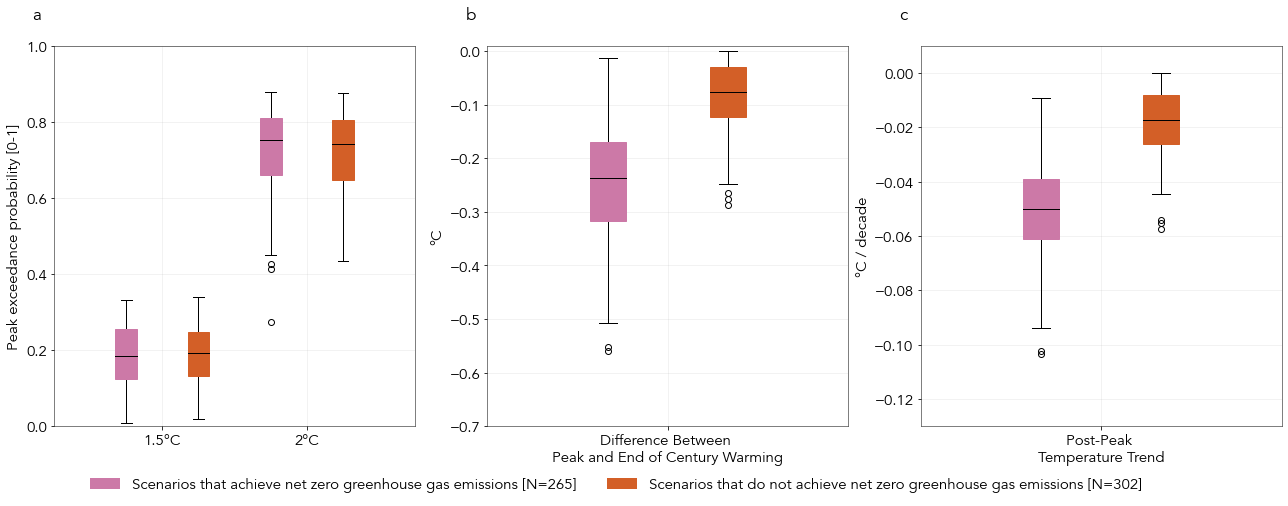

In [22]:
fig, ax = plt.subplots(1,3, figsize=(22,7))

# Panel 1 
for i, var in enumerate(panel_1_variables):
    p1 = ax[0].boxplot(
        panel_1_net_zero[var], 
        positions=[i], 
        patch_artist=True
    )
    p2 = ax[0].boxplot(
        panel_1_no_net_zero[var], 
        positions=[i+0.5], 
        patch_artist=True
    )
    plt.setp(p1['boxes'], color="#cc79a7")
    plt.setp(p1['medians'], color="black")
    plt.setp(p2['boxes'], color="#d35f27")
    plt.setp(p2['medians'], color="black")

ax[0].set_xticks([0.25, 1.25])
ax[0].set_xticklabels(
    [
        "1.5°C",
        "2°C"
    ]
)
ax[0].set_ylabel("Peak exceedance probability [0-1]")
ax[0].set_ylim(0,1)

# Panel 2
for i, var in enumerate(panel_2_variables):
    p1 = ax[i+1].boxplot(
        panel_2_net_zero[var], 
        positions=[i], 
        patch_artist=True
    )
    p2 = ax[i+1].boxplot(
        panel_2_no_net_zero[var], 
        positions=[i+0.5], 
        patch_artist=True
    )
    plt.setp(p1['boxes'], color="#cc79a7")
    plt.setp(p1['medians'], color="black")
    plt.setp(p2['boxes'], color="#d35f27")
    plt.setp(p2['medians'], color="black")

ax[1].set_xticks([0.25])
ax[1].set_xticklabels(["Difference Between \nPeak and End of Century Warming"])
ax[1].set_ylabel("°C")
ax[1].set_ylim(-0.7, 0.01,)

ax[2].set_xticks([1.25])
ax[2].set_xticklabels(["Post-Peak \nTemperature Trend"])
ax[2].set_ylabel("°C / decade")
ax[2].set_ylim(-0.13, 0.01)

n_net_zero = len(panel_2_net_zero[var])
n_no_net_zero = len(panel_2_no_net_zero[var])

# Legend
legend_handles = [ 
    Patch(facecolor="#cc79a7", label="Scenarios that achieve net zero greenhouse gas emissions [N={}]".format(n_net_zero)), 
    Patch(facecolor="#d35f27", label="Scenarios that do not achieve net zero greenhouse gas emissions [N={}]".format(n_no_net_zero))
]
ax[1].legend(
    handles=legend_handles,
    bbox_to_anchor= (1.85, -0.1),
    ncol=2
)


# Annotations
for n,a in enumerate(ax):
    a.text(
        -0.06, 1.07, 
        string.ascii_lowercase[n], 
        transform=a.transAxes,
        size=17, 
        weight='bold'
    )
    a.set_xlabel("")

In [23]:
fig.savefig(
    Path("figures/Figure 2.png"),
    dpi = 100
)

# Figure 3

First, we want to assign the years of net zero emissions (both CO2 and GHG)

In [24]:
def _cross_threshold(x):
    y = pyam.cross_threshold(x, threshold=0.1)
    # set threshold slightly above 0 to catch convergence to 0
    return y[0] if len(y) else 2101 #I adapt this to 2101 to catch the >2100 explicitly

def calculate_netzero(_df):
    return _df.apply(_cross_threshold, raw=False, axis=1)

In [25]:
co2 = (
    df_ar6
    .filter(variable="AR6 climate diagnostics|Infilled|Emissions|CO2")
    .timeseries()
)

In [26]:
df_ar6.set_meta(
    calculate_netzero(co2),
    "netzero|CO2"
)

In [27]:
kyotoghg = (
    df_ar6
    .filter(variable="AR6 climate diagnostics|Infilled|Emissions|Kyoto Gases (AR6-GWP100)")
    .timeseries()
)

In [28]:
df_ar6.set_meta(
    calculate_netzero(kyotoghg),
    "netzero|kyotoghg"
)

Next, we proceed to assign 2030 emission levels.

In [29]:
df_ar6.set_meta_from_data(
    name="Emissions|KyotoGHG|2030", 
    variable="AR6 climate diagnostics|Infilled|Emissions|Kyoto Gases (AR6-GWP100)", 
    year=2030 
)

In [30]:
df_ar6.set_meta_from_data(
    name="Emissions|CO2|2030", 
    variable="AR6 climate diagnostics|Infilled|Emissions|CO2", 
    year=2030 
)

pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend


Text(0, 0.5, 'Gt CO$_2$e')

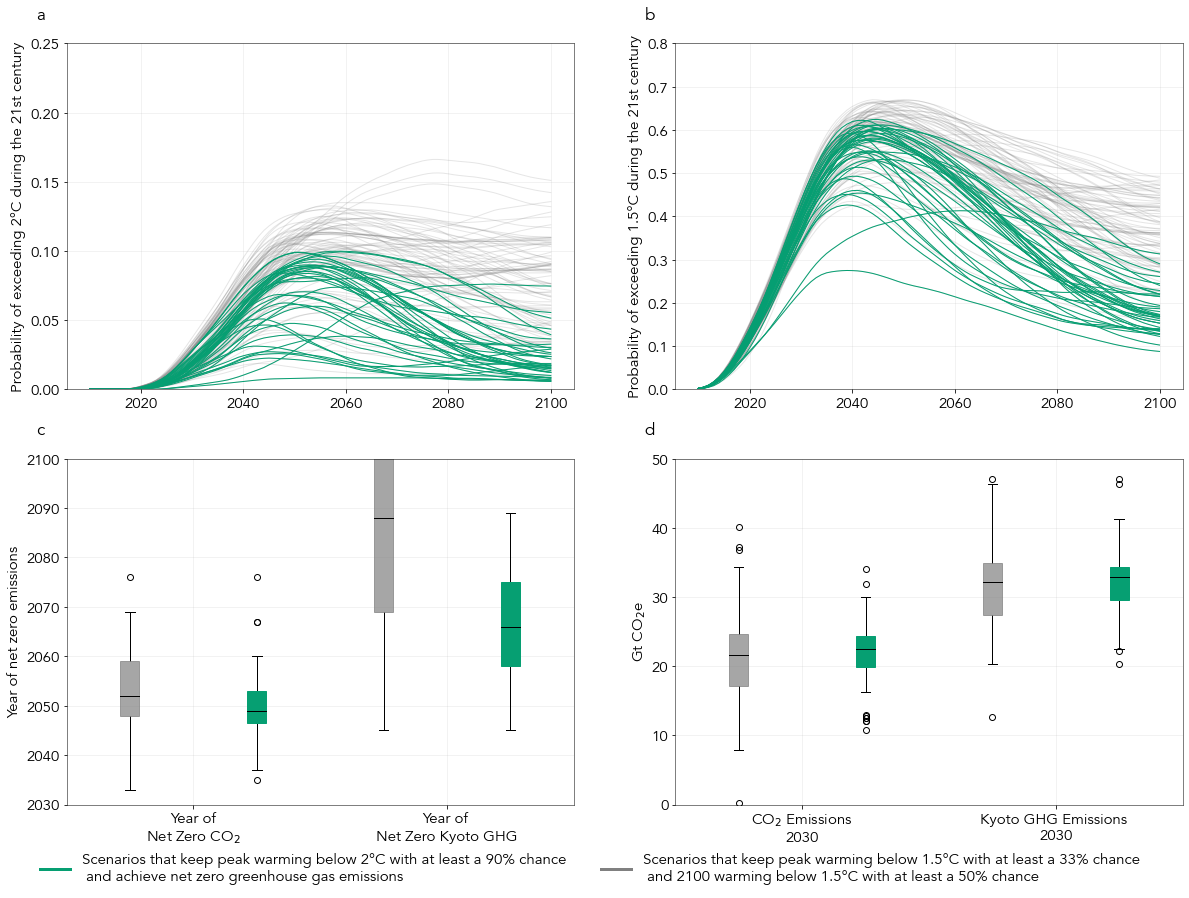

In [31]:
fig, ax = plt.subplots(2,2,figsize = (20,14))
#############
#PANEL 1
#############
df_ar6.filter(
    Category_rolling_mean = "C1",
    variable="AR6 climate diagnostics|Exceedance Probability 2.0C|MAGICCv7.5.3|Rolling Mean"
).plot(
    ax=ax[0,0],
    color="grey",
    alpha=0.2
)
df_ar6.filter(
    category_new_rolling_mean="PA (Art 2 and 4)",
    variable = "AR6 climate diagnostics|Exceedance Probability 2.0C|MAGICCv7.5.3|Rolling Mean"
).plot(
    ax = ax[0,0],
    color = "#069f72",
)

ax[0,0].set_title("")
ax[0,0].set_ylim(0,0.25)
ax[0,0].set_ylabel("Probability of exceeding 2°C during the 21st century")

#############
#PANEL 2
#############
df_ar6.filter(
    Category_rolling_mean="C1",
    variable="AR6 climate diagnostics|Exceedance Probability 1.5C|MAGICCv7.5.3|Rolling Mean"
).plot(
    ax=ax[0,1],
    color="grey",
    alpha=0.2
)
df_ar6.filter(
    category_new_rolling_mean="PA (Art 2 and 4)",
    variable="AR6 climate diagnostics|Exceedance Probability 1.5C|MAGICCv7.5.3|Rolling Mean"
).plot(
    ax=ax[0,1],
    color="#069f72",
)

ax[0,1].set_title("")
ax[0,1].set_ylim(0,0.8)
ax[0,1].set_ylabel("Probability of exceeding 1.5°C during the 21st century")

#############
#PANEL 3
#############
lo_os = df_ar6.filter(Category_rolling_mean="C1").meta
art2 = df_ar6.filter(category_new_rolling_mean="PA (Art 2 and 4)").meta


p1 = ax[1,0].boxplot(
    lo_os["netzero|CO2"], 
    positions=[0], 
    patch_artist=True
)
p2 = ax[1,0].boxplot(
    art2["netzero|CO2"], 
    positions=[1], 
    patch_artist=True
)

p3 = ax[1,0].boxplot(
    lo_os["netzero|kyotoghg"].dropna(), 
    positions=[2], 
    patch_artist=True
)
p4 = ax[1,0].boxplot(
    art2["netzero|kyotoghg"], 
    positions=[3],
    patch_artist=True
)


#############
#PANEL 4
#############
p5 = ax[1,1].boxplot(
    (lo_os["Emissions|CO2|2030"]/1e3).dropna(), 
    positions=[0], 
    patch_artist=True
)
p6 = ax[1,1].boxplot(
    (art2["Emissions|CO2|2030"]/1e3).dropna(), 
    positions=[1],
    patch_artist=True
)

p7 = ax[1,1].boxplot(
    (lo_os["Emissions|KyotoGHG|2030"]/1e3).dropna(), 
    positions=[2], 
    patch_artist=True
)
p8 = ax[1,1].boxplot(
    (art2["Emissions|KyotoGHG|2030"]/1e3).dropna(), 
    positions=[3],
    patch_artist=True,
)


for p in [p2, p4, p6, p8]:
    plt.setp(p['boxes'], color="#069f72")
    plt.setp(p['medians'], color='black')  

for p in [p1, p3, p5, p7]:
    plt.setp(p['boxes'], color="grey", alpha=0.7)
    plt.setp(p['medians'], color='black')  

ax[1,0].set_ylim(2030,2100)
ax[1,0].set_xticks([0.5, 2.5])
ax[1,0].set_xticklabels(
    [ 
        "Year of\nNet Zero CO$_2$", 
        "Year of \nNet Zero Kyoto GHG"
    ]
)

ax[1,1].set_ylim(0, 50)
ax[1,1].set_xticks([0.5, 2.5])
ax[1,1].set_xticklabels(
    [ 
        "CO$_2$ Emissions\n2030", 
        "Kyoto GHG Emissions \n2030"
    ]
)

####################
#Additional elements
####################
for n,a in enumerate(ax[0]):
    a.text(
        -0.06, 1.07, 
        string.ascii_lowercase[n], 
        transform=a.transAxes,
        size=17, 
        weight='bold'
    )
    a.set_xlabel("")

for n,a in enumerate(ax[1]):
    a.text(
        -0.06, 1.07, 
        string.ascii_lowercase[n+2], 
        transform=a.transAxes,
        size=17, 
        weight='bold'
    )
    a.set_xlabel("")

# Add custom legend 
# Custom legend 
legend_elements = [ 
    Line2D([0], [0], color='#069f72', lw=3, label="Scenarios that keep peak warming below 2°C with at least a 90% chance \n and achieve net zero greenhouse gas emissions"), 
    Line2D([0], [0], color='grey',lw = 3, label="Scenarios that keep peak warming below 1.5°C with at least a 33% chance \n and 2100 warming below 1.5°C with at least a 50% chance")
]

ax[1,0].legend(
    handles=legend_elements,
    bbox_to_anchor=(2.15, -0.1),
    ncol=2
)
ax[1,0].set_ylabel("Year of net zero emissions")
ax[1,1].set_ylabel("Gt CO$_2$e")

In [32]:
fig.savefig(
    Path("figures/Figure 3.png"),
    dpi = 1000
)

# Statistics for text

In [33]:
cols_to_summarise = [
    "netzero|kyotoghg", 
    "netzero|CO2",
    "Emissions|CO2|2030",
    "Emissions|KyotoGHG|2030",
]

In [34]:
analysis_data = df_ar6.filter(
    netzero=True
).meta

In [35]:
analysis_data.groupby(
    "Category_rolling_mean"
)[cols_to_summarise].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9]).to_excel("tables/Table_for_Fig3.xlsx")